# Advesarial Patch

In [29]:
import os
import json

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
CHECKPOINT_PATH = './saved_models/'


In [2]:
# Mean and Std from CIFAR-10
NORM_MEAN = np.array([0.491, 0.482, 0.446])
NORM_STD = np.array([0.247, 0.243, 0.261])

# No resizing and center crop necessary as images are already preprocessed.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])


# Check if CUDA is available and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

label_names = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

Using device: cuda:0


In [4]:
# Load CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# TODO: Load the pretrained cifar 10 model from the hub and do the untargeted/targeted training 
MODEL_NAMEs = ['resnet20', 'resnet32', 'vgg16', 'vgg19', 'densenet121', 'densenet161']
# Load model and move to device
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Function to calculate accuracy
def calculate_accuracy(net, dataloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# # Evaluate on the training data
# train_accuracy = calculate_accuracy(model, trainloader, device)
# print('Accuracy of the network on the training images: %d %%' % train_accuracy)

# Evaluate on the test data
test_accuracy = calculate_accuracy(model, testloader, device)
print('Accuracy of the network on the test images: %d %%' % test_accuracy)


Files already downloaded and verified
Files already downloaded and verified


Using cache found in /home/yo46/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Accuracy of the network on the test images: 92 %


In [5]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [9]:
_ = eval_model(testloader)

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Top-1 error: 7.88%
Top-5 error: 0.18%


In [10]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

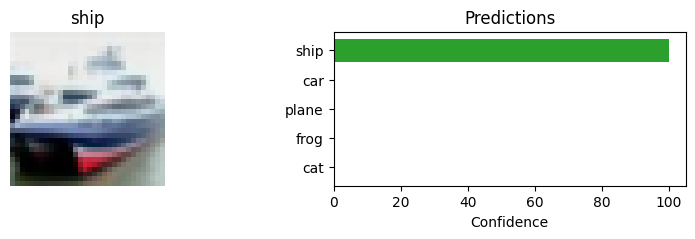

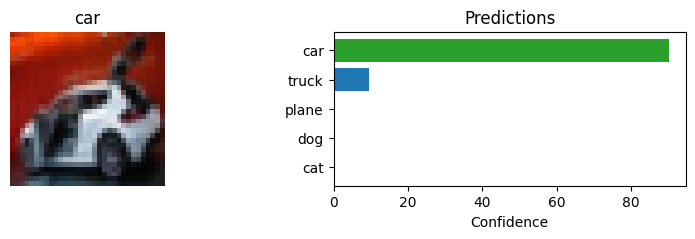

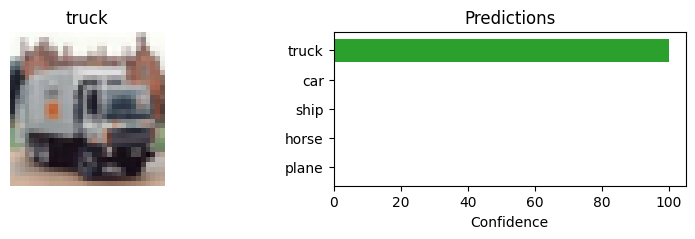

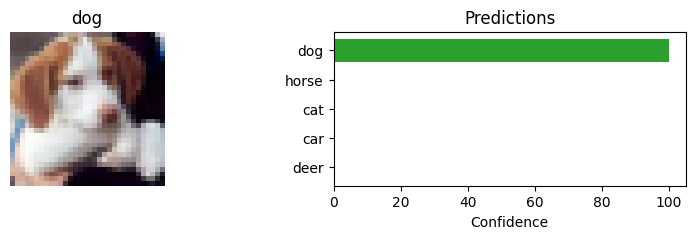

In [12]:
exmp_batch, label_batch = next(iter(testloader))
with torch.no_grad():
    preds = model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

## Place Patch into imgs and train

In [14]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [15]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [16]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4): 
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [58]:
def create_initial_patch(size=(10, 10), device='cpu'):
    """Create an initial random patch."""
    patch = torch.rand((3,) + size, requires_grad=True, device=device)  # Add channel dimension
    return patch

def apply_patch(original_images, patch):
    """Apply the patch to the top-left corner of each image in a batch."""
    patched_images = original_images.clone()
    c, h, w = patch.shape  # Get the shape of the patch
    patched_images[:, :, :h, :w] = patch  # Apply the patch
    return patched_images

def train_patch(model, patch, train_loader, device='cpu', epochs=5):
    """Train the patch to perform an untargeted attack."""
    optimizer = torch.optim.Adam([patch], lr=0.01)

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0

        for images, _ in train_loader:
            images = images.to(device)
            patched_images = apply_patch(images, patch)

            outputs = model(patched_images)
            loss = -torch.nn.functional.nll_loss(outputs, outputs.max(1)[1])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        average_loss = total_loss / num_batches
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {average_loss:.4f}")
    # save the patch
    torch.save(patch, f'./saved_models/{MODEL_NAMEs[0]}/untargeted_patch_{patch_size[0]}x{patch_size[1]}_ep{epochs}_dire_tl.pt')
    return patch


# Create the initial patch
patch_size = (3, 3)  # Define the size of the patch
initial_patch = create_initial_patch(size=patch_size, device=device)

# Train the patch
trained_patch = train_patch(model, initial_patch, trainloader, device=device, epochs=20)

Epoch [1/20], Average Loss: 11.8375
Epoch [2/20], Average Loss: 10.7402
Epoch [3/20], Average Loss: 10.0036


KeyboardInterrupt: 

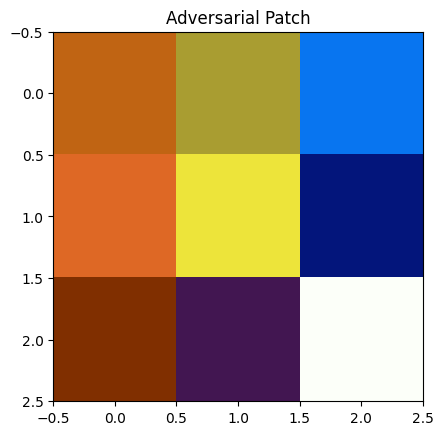

In [22]:
# visualize the trained patch here 
def visualize_patch(patch):
    """Visualize the adversarial patch."""
    # Move patch to CPU and convert to numpy
    patch_np = patch.detach().cpu().numpy()
    
    # Reshape and normalize the patch for visualization
    patch_np = np.transpose(patch_np, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    patch_np = (patch_np - patch_np.min()) / (patch_np.max() - patch_np.min())  # Normalize to [0, 1]

    plt.imshow(patch_np)
    plt.title("Adversarial Patch")
    plt.show()

# Visualize the trained patch
visualize_patch(trained_patch)

## Untargeted

In [23]:
def test_model_with_patch(model, patch, test_loader, device):
    """Evaluate the model on the test set with the adversarial patch applied."""
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predicted_distribution = torch.zeros(len(test_loader.dataset.classes), dtype=torch.int64)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            patched_images = apply_patch(images, patch)  # Apply the patch

            outputs = model(patched_images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            for label in predicted:
                predicted_distribution[label] += 1

    accuracy = 100 * correct / total
    return accuracy, predicted_distribution

accuracy_after_attack, label_distribution = test_model_with_patch(model, trained_patch, testloader, device)

print('Accuracy of the model after the attack: {:.2f} %'.format(accuracy_after_attack))
print('Predicted label distribution:', label_distribution.numpy())

Accuracy of the model after the attack: 47.41 %
Predicted label distribution: [ 351 1343  905 2179  167 2507  255 1335   30  928]


In [53]:
def train_patch_targeted(model, patch, train_loader, target_class, device='cpu', epochs=5):
    """Train the patch to perform a targeted attack."""
    optimizer = torch.optim.Adam([patch], lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for images, _ in train_loader:
            target_labels = torch.full((len(images),), target_class, device=device)
            images = images.to(device)
            patched_images = apply_patch(images, patch)

            optimizer.zero_grad()
            outputs = model(patched_images)
            loss = criterion(outputs, target_labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return patch

patch_size = (10, 10)  # Define the size of the patch
initial_patch = create_initial_patch(size=patch_size, device=device)
target_class = 5  # Example: 0 for the first class in CIFAR-10
trained_patch_targeted = train_patch_targeted(model, initial_patch, trainloader, target_class, device=device, epochs=20)


Epoch [1/20], Loss: 0.3464
Epoch [2/20], Loss: 0.2037
Epoch [3/20], Loss: 0.1510


KeyboardInterrupt: 

In [26]:
accuracy_after_attack, label_distribution = test_model_with_patch(model, trained_patch_targeted, testloader, device)

print('Accuracy of the model after the attack: {:.2f} %'.format(accuracy_after_attack))
print('Predicted label distribution:', label_distribution.numpy())

Accuracy of the model after the attack: 10.69 %
Predicted label distribution: [   3   10    1    3   11 9931    1    7    4   29]


## Targeted

### training process

In [56]:
def patch_attack(model, target_class, patch_size=3, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    
    
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, drop_last=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    # optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    optimizer = torch.optim.Adam([patch], lr=0.01)
    loss_module = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss.mean():.4f}")
        
    
    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    
    return patch.data, {"acc": acc.item(), "top5": top5.item()}


In [57]:
patch_attack(model, target_class=5, patch_size=(10,10), num_epochs=20)

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [1/20], Average Loss: 0.2615


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [2/20], Average Loss: 0.1527


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [3/20], Average Loss: 0.2056


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [4/20], Average Loss: 0.1286


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [5/20], Average Loss: 0.0500


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch [6/20], Average Loss: 0.1356


  0%|          | 0/390 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)
        
# Save the new patches via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t 
                                   for t in patch_dict[cname][psize]["results"]] 
                           for psize in patch_dict[cname]} 
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [48]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(model, patch, testloader, target_class=c)    
            
            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }
        
    return result_dict

In [49]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # 
patch_sizes = [3, 5, 7, 9, 16]

patch_dict = get_patches(class_names, patch_sizes)
save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validation results for bird and 9: {'acc': 0.9286944270133972, 'top5': 0.9996111392974854}


Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validation results for bird and 16: {'acc': 0.9998055696487427, 'top5': 1.0}


Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

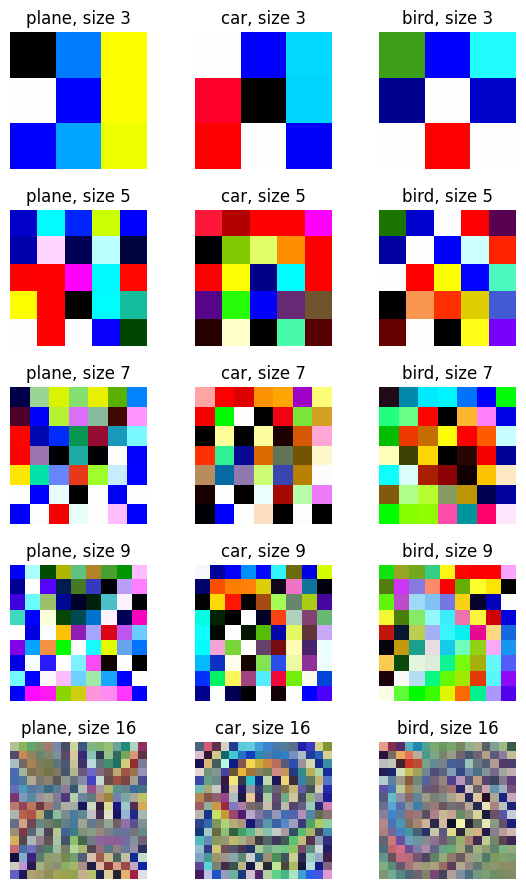

In [50]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

In [59]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [60]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

In [61]:
# top-1 accuracy
show_table(top_1=True)

Class name,Patch size 3x3,Patch size 5x5,Patch size 7x7,Patch size 9x9,Patch size 16x16
plane,16.17%,32.36%,67.21%,87.59%,99.99%
car,1.50%,25.87%,59.22%,81.13%,99.99%
bird,22.00%,35.36%,75.02%,92.78%,99.98%


In [62]:
# top-5 accuracy
show_table(top_1=False)

Class name,Patch size 3x3,Patch size 5x5,Patch size 7x7,Patch size 9x9,Patch size 16x16
plane,83.31%,92.57%,98.91%,99.91%,100.00%
car,56.25%,91.56%,98.36%,99.93%,100.00%
bird,86.21%,92.08%,99.20%,99.97%,100.00%


In [64]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

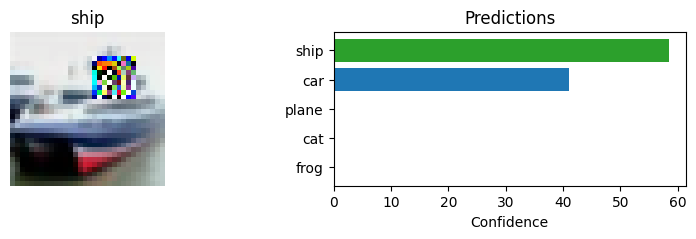

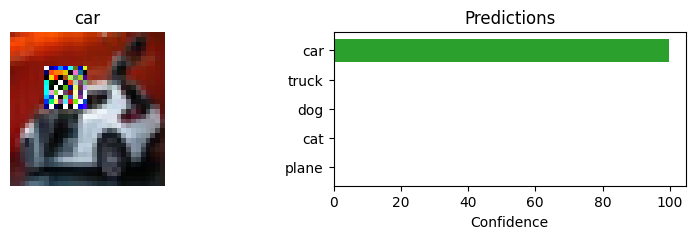

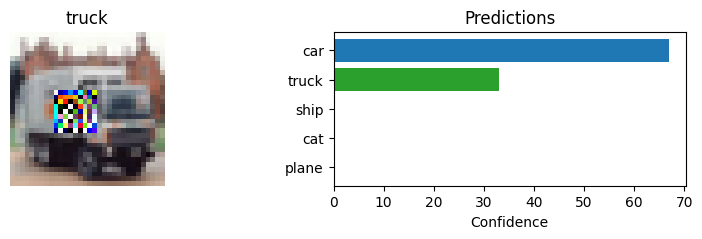

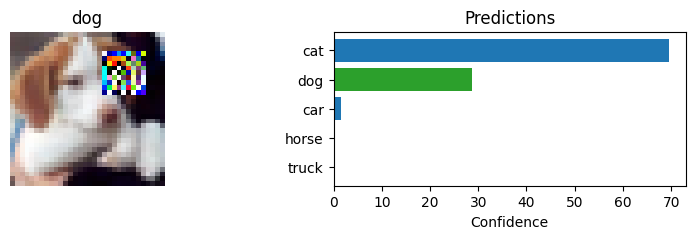

In [67]:
perform_patch_attack(patch_dict['car'][9]['patch'])

### Transferability of white-box attacks

FGSM and the adversarial patch attack were both focused on one specific image. However, can we transfer those attacks to other models? The adversarial patch attack as proposed in [Brown et al.](https://arxiv.org/pdf/1712.09665.pdf), was originally trained on multiple models, and hence was also able to work on many different network architecture. But how different are the patches for different models anyway? For instance, let's evaluate some of our patches trained above on a different network, e.g. DenseNet121.

In [76]:
#TODO: Load the pretrained cifar 10 model from the hub and test the transferability of the patch
transfer_model = torchvision.models.densenet121(pretrained=True)
transfer_model = transfer_model.to(device)

# No gradients needed for the network
transfer_model.eval()
for p in transfer_model.parameters():
    p.requires_grad = False

/home/yo46/anaconda3/envs/llmattack/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yo46/anaconda3/envs/llmattack/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
class_name = 'car'
patch_size = 16
print(f"Testing patch \"{class_name}\" of size {patch_size}x{patch_size}")

results = eval_patch(transfer_model, 
                     patch_dict[class_name][patch_size]["patch"], 
                     testloader, 
                     target_class=label_names.index(class_name))

print(f"Top-1 fool accuracy: {(results[0] * 100.0):4.2f}%")
print(f"Top-5 fool accuracy: {(results[1] * 100.0):4.2f}%")

Testing patch "car" of size 16x16


Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Top-1 fool accuracy: 0.00%
Top-5 fool accuracy: 0.00%
